In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"muskang","key":"25c0d14de4a19d1e5957b5cf36f4d42a"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import zipfile
with zipfile.ZipFile("chest-xray-pneumonia.zip","r") as zip_ref:
    zip_ref.extractall("")

In [0]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.metrics import error_rate

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
labels = os.listdir("/content/chest_xray/chest_xray/train")
print("No. of labels: {}".format(len(labels)))
print("-----------------")

No. of labels: 3
-----------------


In [0]:
for label in labels:
    print('Train: '+"{}, {} files".format(label, len(os.listdir("/content/chest_xray/train/"+ label))))
    print('Validation: '+"{}, {} files".format(label, len(os.listdir("/content/chest_xray/val/"+ label))))
    print('Test: '+"{}, {} files".format(label, len(os.listdir("/content/chest_xray/test/"+ label))))

Train: NORMAL, 1341 files
Validation: NORMAL, 8 files
Test: NORMAL, 234 files
Train: PNEUMONIA, 3875 files
Validation: PNEUMONIA, 8 files
Test: PNEUMONIA, 390 files


FileNotFoundError: ignored

In [0]:
path = "/content/chest_xray/chest_xray/train"
size = 224 #Files in ImageNet are of size 224, and as that is what we are training on, size =224.
bs = 64

In [0]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(do_flip=True, flip_vert=True),
                                  valid_pct=0.3, size=size, bs=bs)

In [0]:
data.normalize(imagenet_stats) 
#Normaize so that all channels are given equal weightage, as they are all fitted in same range
#ImageNet stats gives the mean, medians, std. deviations based on which the normalization is done
'''
Reason for normalisation:
For Activation functions like sigmoid and tanh, the output after -3 and 3 does not change even with 
massive changes in input.
The output will remain the same for 10 and 1000. 
Hence, normalizeing it, will get it in the range of -1,1 which will show proper changes in gradient for 
different inputs.
'''

'\nReason for normalisation:\nFor Activation functions like sigmoid and tanh, the output after -3 and 3 does not change even with \nmassive changes in input.\nThe output will remain the same for 10 and 1000. \nHence, normalizeing it, will get it in the range of -1,1 which will show proper changes in gradient for \ndifferent inputs.\n'

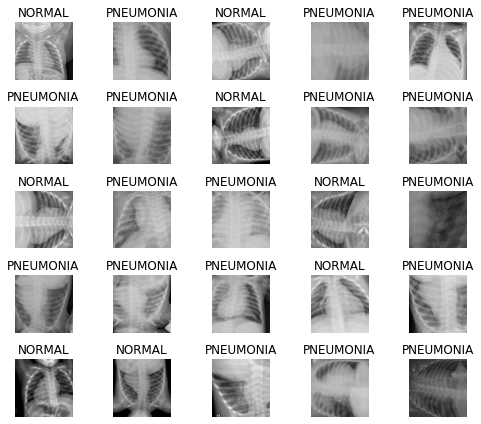

In [0]:
data.show_batch(rows=5, figsize=(7,6))

In [0]:
learner = cnn_learner(data, models.resnet50, metrics=[accuracy], callback_fns=ShowGraph)
#Callbacks- Keeps a record of all the metrics that are needed to be tracked like accuracy with different parameters

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


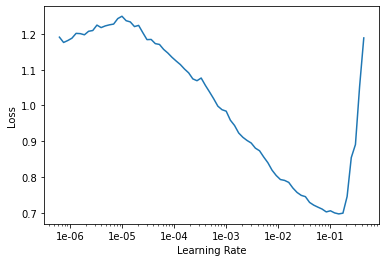

In [0]:
learner.lr_find() 
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.380626,0.221319,0.944373,03:17
1,0.521099,2.663014,0.730818,03:08
2,0.458367,0.152956,0.944373,03:08
3,0.263295,0.128166,0.958440,03:08
4,0.176422,0.135704,0.953964,03:06
5,0.129529,0.066825,0.979540,03:06
6,0.110108,0.108322,0.960358,03:10
7,0.099854,0.067709,0.976343,03:06


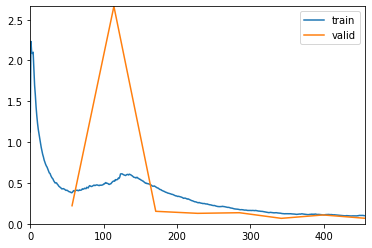

'\nx - number of steps\ny - loss\nnumber of steps per epoch = training_size / batch_size\n'

In [0]:
learner.fit_one_cycle(8, max_lr=slice(1e-2, 1e-1))
'''
x - number of steps
y - loss
number of steps per epoch = training_size / batch_size
'''

In [0]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


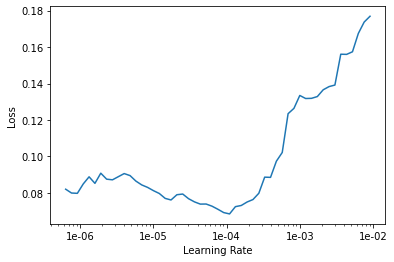

In [0]:
learner.lr_find() 
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.077291,0.070235,0.975703,03:09
1,0.076208,0.055714,0.980818,03:13
2,0.079442,0.110373,0.955243,03:14
3,0.075387,0.050233,0.982737,03:17
4,0.073974,0.066067,0.969949,03:21
5,0.065803,0.065547,0.971867,03:20


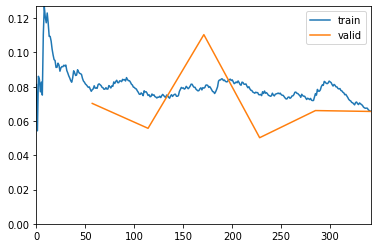

In [0]:
learner.fit_one_cycle(6, max_lr=slice(1e-5, 1e-4)) 
#We will take the learning rate based on the plot got from recorder_plot
#Slice is used for proportionately distributing:
#Left most layer will have lr as e-5, right most layer will have lr as e-4
#All layers in between will have propotionally lr between e-5 and e-4

In [0]:
learner.save('my_best_weights')

In [0]:
learner.load('my_best_weights')

In [0]:
size= 256
bs= 64

In [0]:
data = ImageDataBunch.from_folder(path='/content/chest_xray/',train='train', valid= 'test',
                                  ds_tfms=get_transforms(do_flip=True, flip_vert=True), size=size, bs=bs)
data.normalize(imagenet_stats) 

ImageDataBunch;

Train: LabelList (5216 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: /content/chest_xray;

Valid: LabelList (624 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: /content/chest_xray;

Test: None

In [0]:
learner = cnn_learner(data, models.resnet50, metrics=[accuracy], callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


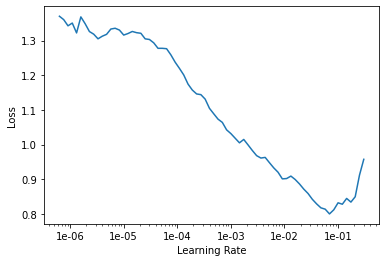

In [0]:
learner.lr_find() 
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.334324,1.658943,0.794872,04:23
1,0.329641,0.466257,0.887821,04:22
2,0.257252,0.263207,0.910256,04:23
3,0.198127,0.258777,0.916667,04:22
4,0.120736,0.413277,0.891026,04:23
5,0.092349,0.266845,0.918269,04:25


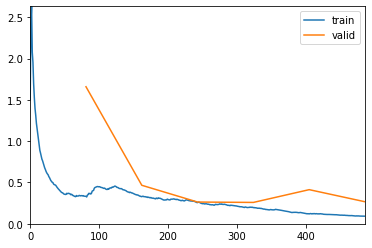

In [0]:
learner.fit_one_cycle(6, max_lr=slice(1e-2, 1e-1))

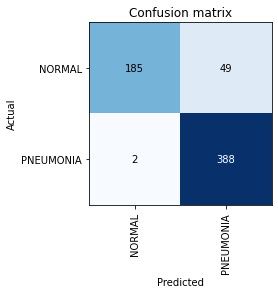

In [0]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()